Image Preprocessing Pipelines 

Pipeline 1: Raw Images
Pipeline 2: Normalization (MobileNetV2 preprocessing)
Pipeline 3: Normalization + CLAHE
Pipeline 4: Normalization + Denoising + CLAHE
Pipeline 5: Normalization + CLAHE + Data Augmentation
Pipeline 6: CLAHE + Normalization + Augmentation + Dataset Expansion
Pipeline 7: Normalization + Dataset Expansion

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import cv2

In [4]:
# Load paths and labels

data_dir = "./dataset"   
classes = ["normal", "osteoporosis"]

all_image_paths = []
all_labels = []
for idx, cls in enumerate(classes):
    paths = glob(os.path.join(data_dir, cls, "*"))
    all_image_paths.extend(paths)
    all_labels.extend([idx]*len(paths))

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print("Total images:", len(all_image_paths))

Total images: 372


In [5]:
# Inspect dataset and collect filepaths & labels
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_to_index = {c:i for i,c in enumerate(classes)}
print("Classes:", classes)

filepaths = []
labels = []
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    files = sorted(glob(os.path.join(cls_dir, "*")))
    print(f"Found {len(files)} images in {cls}")
    for f in files:
        filepaths.append(os.path.abspath(f))
        labels.append(class_to_index[cls])

filepaths = np.array(filepaths)
labels = np.array(labels)
print("Total images:", len(filepaths))


Classes: ['normal', 'osteoporosis']
Found 186 images in normal
Found 186 images in osteoporosis
Total images: 372


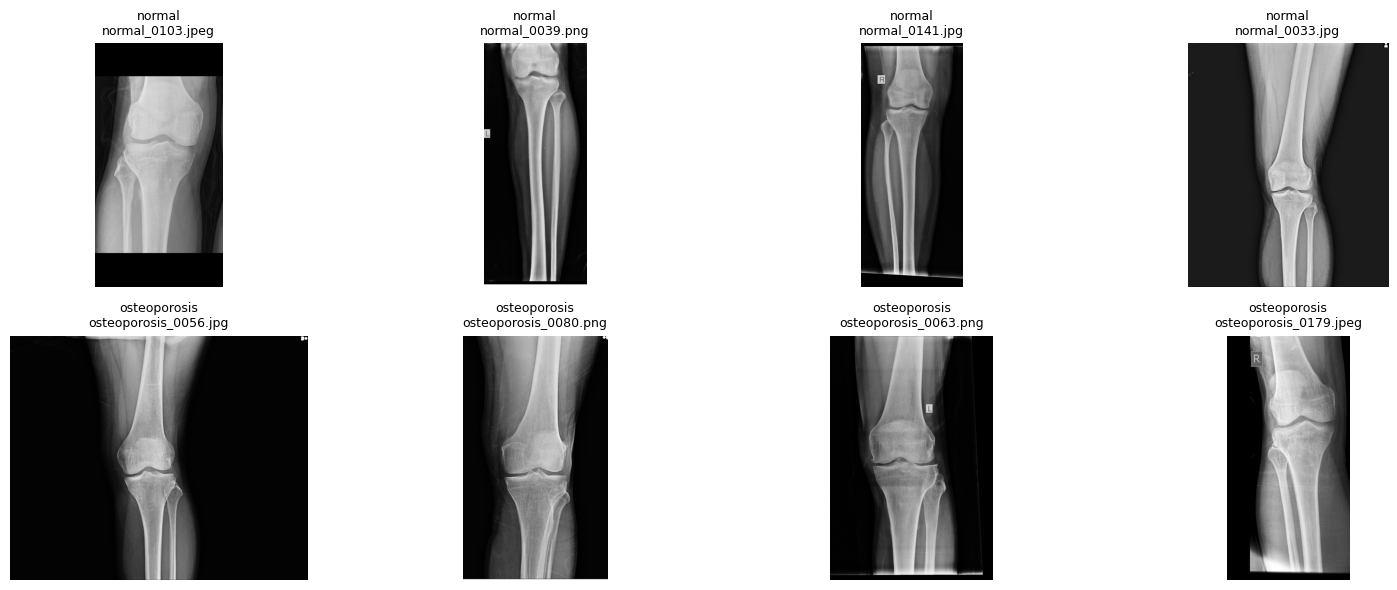

In [6]:
# Visualize 4 images per class
def show_samples(base_dir, classes, n_per_class=4):
    plt.figure(figsize=(4*n_per_class, 6))
    for i, cls in enumerate(classes):
        files = sorted(glob(os.path.join(base_dir, cls, "*")))
        random.shuffle(files)
        files = files[:n_per_class]
        for j, fp in enumerate(files):
            ax = plt.subplot(len(classes), n_per_class, i*n_per_class + j + 1)
            img = Image.open(fp).convert("RGB")
            plt.imshow(img)
            ax.set_title(f"{cls}\n{Path(fp).name}", fontsize=9)
            ax.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(data_dir, classes, n_per_class=4)


In [7]:
# Split data

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels, stratify=all_labels, test_size=0.3, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, stratify=temp_labels, test_size=0.5, random_state=42
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

Train: 260, Val: 56, Test: 56


In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
# HELPER FUNCTIONS


def safe_resize(img):
    """Resize safely with OpenCV."""
    try:
        img = cv2.resize(img, IMG_SIZE)
    except:
        img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    return img

def apply_clahe(img):
    """Apply CLAHE preprocessing."""
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_img = clahe.apply(gray)
        img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)
    except:
        img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    return img

def apply_denoise_clahe(img):
    """Apply denoising + CLAHE preprocessing."""
    try:
        img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_img = clahe.apply(gray)
        img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)
    except:
        img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    return img


In [10]:
# =========================
# PIPELINE PREPROCESSORS
# =========================

# PIPELINE 1: Raw Images 
def preprocess_1(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)      # grayscale
    img = tf.image.resize(img, IMG_SIZE)          # resize
    img = tf.image.grayscale_to_rgb(img)          # convert to RGB for pretrained models
    return img, label

# PIPELINE 2: Normalization (MobileNetV2 preprocess) 
def preprocess_2(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)      # grayscale
    img = tf.image.resize(img, IMG_SIZE)          # resize
    img = tf.image.grayscale_to_rgb(img)          # convert to RGB
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)  # normalize
    return img, label

# Pipeline 3: Normalization + CLAHE
def preprocess_3_img(path, label):
    def _process(path_str):
        img = cv2.imread(path_str.decode(), cv2.IMREAD_COLOR)
        if img is None:
            img = np.zeros((224, 224, 3), dtype=np.uint8)  # fallback
        else:
            img = cv2.resize(img, (224, 224))
            img = apply_clahe(img)
        img = img.astype("float32") / 255.0
        return img
    img = tf.numpy_function(_process, [path], tf.float32)
    img = tf.ensure_shape(img, (224, 224, 3))   # ✅ important
    return img, label

# Pipeline 4: Normalization + Denoising + CLAHE
def preprocess_4_img(path, label):
    def _process(path_str):
        img = cv2.imread(path_str.decode(), cv2.IMREAD_COLOR)
        if img is None:
            img = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            img = cv2.resize(img, (224, 224))
            img = apply_denoise_clahe(img)
        img = img.astype("float32") / 255.0
        return img
    img = tf.numpy_function(_process, [path], tf.float32)
    img = tf.ensure_shape(img, (224, 224, 3))
    return img, label

# Pipeline 5: Normalization + CLAHE + Data Augmentation
def preprocess_5_img(path, label):
    def _process(path_str):
        img = cv2.imread(path_str.decode(), cv2.IMREAD_COLOR)
        if img is None:
            img = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            img = cv2.resize(img, (224, 224))
            img = apply_clahe(img)
        img = img.astype("float32") / 255.0
        return img
    img = tf.numpy_function(_process, [path], tf.float32)
    img = tf.ensure_shape(img, (224, 224, 3))

    # ✅ Safe TF augmentations (inside graph)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)

    return img, label

# Pipeline 6: CLAHE + Normalization + Augmentation + Dataset Expansion
def preprocess_6_img(path, label):
    """Preprocess: resize + CLAHE + normalization"""
    def _process(path_str):
        img = cv2.imread(path_str.decode(), cv2.IMREAD_COLOR)
        if img is None:
            img = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            img = cv2.resize(img, (224, 224))
            img = apply_clahe(img)
        img = img.astype("float32") / 255.0
        return img
    img = tf.numpy_function(_process, [path], tf.float32)
    img = tf.ensure_shape(img, (224, 224, 3))
    return img, label


def augment_image(img, label, num_aug=2):
    """Return dataset with original + num_aug augmented copies"""
    datasets = []

    # original
    datasets.append(tf.data.Dataset.from_tensors((img, label)))

    # augmented copies
    for _ in range(num_aug):
        aug_img = tf.image.random_flip_left_right(img)
        aug_img = tf.image.random_brightness(aug_img, max_delta=0.1)
        aug_img = tf.image.random_contrast(aug_img, 0.9, 1.1)
        datasets.append(tf.data.Dataset.from_tensors((aug_img, label)))

    # merge all datasets
    ds = datasets[0]
    for extra in datasets[1:]:
        ds = ds.concatenate(extra)

    return ds

In [11]:
# --- Generic Dataset Builder ---
def make_dataset(paths, labels, batch_size=16, shuffle=True, pipeline=1):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if pipeline == 1:
        ds = ds.map(preprocess_1, num_parallel_calls=tf.data.AUTOTUNE)
    elif pipeline == 2:
        ds = ds.map(preprocess_2, num_parallel_calls=tf.data.AUTOTUNE)
    # in future you can add: elif pipeline==3: preprocess_3 ...

    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# --- Create Datasets for Pipeline 1 (Raw Images) ---
train_ds_1 = make_dataset(train_paths, train_labels, batch_size=16, pipeline=1)
val_ds_1   = make_dataset(val_paths, val_labels, batch_size=16, shuffle=False, pipeline=1)
test_ds_1  = make_dataset(test_paths, test_labels, batch_size=16, shuffle=False, pipeline=1)

# --- Create Datasets for Pipeline 2 (Normalized) ---
train_ds_2 = make_dataset(train_paths, train_labels, batch_size=16, pipeline=2)
val_ds_2   = make_dataset(val_paths, val_labels, batch_size=16, shuffle=False, pipeline=2)
test_ds_2  = make_dataset(test_paths, test_labels, batch_size=16, shuffle=False, pipeline=2)

# --- Pipeline 3 ---
train_ds_3 = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .map(preprocess_3_img, num_parallel_calls=AUTOTUNE)
    .shuffle(256).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

val_ds_3 = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(preprocess_3_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

test_ds_3 = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(preprocess_3_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

# --- Pipeline 4 ---
train_ds_4 = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .map(preprocess_4_img, num_parallel_calls=AUTOTUNE)
    .shuffle(256).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

val_ds_4 = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(preprocess_4_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

test_ds_4 = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(preprocess_4_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

# --- Pipeline 5 ---
train_ds_5 = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .map(preprocess_5_img, num_parallel_calls=AUTOTUNE)
    .shuffle(256).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

val_ds_5 = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(preprocess_5_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

test_ds_5 = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(preprocess_5_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)


def make_dataset_6(paths, labels, num_aug=2):
    """Build dataset for pipeline 6 with expansion"""
    base_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    base_ds = base_ds.map(preprocess_6_img, num_parallel_calls=AUTOTUNE)

    # expand dataset: each image → original + num_aug augmentations
    base_ds = base_ds.flat_map(lambda x, y: augment_image(x, y, num_aug))

    return base_ds.shuffle(512).batch(BATCH_SIZE).prefetch(AUTOTUNE)


# Build datasets for Pipeline 6
train_ds_6 = make_dataset_6(train_paths, train_labels, num_aug=2)  # tripled
val_ds_6   = make_dataset_6(val_paths, val_labels, num_aug=0)      # no augmentation
test_ds_6  = make_dataset_6(test_paths, test_labels, num_aug=0)    # no augmentation


In [12]:
# -------------------------------
# Function to count dataset items
# -------------------------------
def dataset_size(ds):
    return sum(1 for _ in ds.unbatch())

# -------------------------------
# Pipeline 1
# -------------------------------
train_count_1 = dataset_size(train_ds_1)
val_count_1   = dataset_size(val_ds_1)
test_count_1  = dataset_size(test_ds_1)

# -------------------------------
# Pipeline 2
# -------------------------------
train_count_2 = dataset_size(train_ds_2)
val_count_2   = dataset_size(val_ds_2)
test_count_2  = dataset_size(test_ds_2)

# -------------------------------
# Pipeline 3
# -------------------------------
train_count_3 = dataset_size(train_ds_3)
val_count_3   = dataset_size(val_ds_3)
test_count_3  = dataset_size(test_ds_3)

# -------------------------------
# Pipeline 4
# -------------------------------
train_count_4 = dataset_size(train_ds_4)
val_count_4   = dataset_size(val_ds_4)
test_count_4  = dataset_size(test_ds_4)

# -------------------------------
# Pipeline 5
# -------------------------------
train_count_5 = dataset_size(train_ds_5)
val_count_5   = dataset_size(val_ds_5)
test_count_5  = dataset_size(test_ds_5)

# -------------------------------
# Pipeline 6
# -------------------------------
train_count_6 = dataset_size(train_ds_6)
val_count_6   = dataset_size(val_ds_6)
test_count_6  = dataset_size(test_ds_6)

# -------------------------------
# Print results
# -------------------------------
print("\n=== Dataset Sizes for All Pipelines ===")
for i in range(1, 7):
    print(f"\nPipeline {i}:")
    print(f"  Train set size: {eval(f'train_count_{i}')}")
    print(f"  Val set size  : {eval(f'val_count_{i}')}")
    print(f"  Test set size : {eval(f'test_count_{i}')}")



=== Dataset Sizes for All Pipelines ===

Pipeline 1:
  Train set size: 260
  Val set size  : 56
  Test set size : 56

Pipeline 2:
  Train set size: 260
  Val set size  : 56
  Test set size : 56

Pipeline 3:
  Train set size: 260
  Val set size  : 56
  Test set size : 56

Pipeline 4:
  Train set size: 260
  Val set size  : 56
  Test set size : 56

Pipeline 5:
  Train set size: 260
  Val set size  : 56
  Test set size : 56

Pipeline 6:
  Train set size: 780
  Val set size  : 56
  Test set size : 56


In [13]:
# Model 1
base_model_1 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_1.trainable = False

model_1 = tf.keras.Sequential([
    base_model_1,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_1.summary()



# Model 2
base_model_2 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_2.trainable = False

model_2 = tf.keras.Sequential([
    base_model_2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_2.summary()


# Model
base_model_3 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_3.trainable = False

model_3 = tf.keras.Sequential([
    base_model_3,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_3.summary()


# Model 4
base_model_4 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_4.trainable = False

model_4 = tf.keras.Sequential([
    base_model_4,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_4.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_4.summary()



# Model 5
base_model_5 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_5.trainable = False

model_5 = tf.keras.Sequential([
    base_model_5,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_5.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_5.summary()


# Model 6
base_model_6 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_6.trainable = False

model_6 = tf.keras.Sequential([
    base_model_6,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_6.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_6.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
print("\nTraining PIPELINE 1 (Raw Images)...\n")
history_1 = model_1.fit(train_ds_1, validation_data=val_ds_1, epochs=10)


Training PIPELINE 1 (Raw Images)...

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6000 - loss: 0.7267 - val_accuracy: 0.6071 - val_loss: 0.6423
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 548ms/step - accuracy: 0.6038 - loss: 0.7359 - val_accuracy: 0.6786 - val_loss: 0.6224
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 572ms/step - accuracy: 0.6154 - loss: 0.6855 - val_accuracy: 0.6786 - val_loss: 0.6015
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 500ms/step - accuracy: 0.5846 - loss: 0.6562 - val_accuracy: 0.7321 - val_loss: 0.5895
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 562ms/step - accuracy: 0.6385 - loss: 0.6437 - val_accuracy: 0.7500 - val_loss: 0.5797
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 506ms/step - accuracy: 0.6308 - loss: 0.6254 - val_accuracy: 0.7500 - val_loss: 0.5728
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 479ms/step - accuracy: 0.6423 - loss: 0.6331 - val_accuracy: 0.7500 - val_loss: 0.5645
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - accurac

In [15]:
print("\nTraining PIPELINE 2 (Normalization Only)...\n")
history_2 = model_2.fit(train_ds_2, validation_data=val_ds_2, epochs=10)


Training PIPELINE 2 (Normalization Only)...

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 897ms/step - accuracy: 0.5115 - loss: 0.8039 - val_accuracy: 0.5893 - val_loss: 0.6810
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 513ms/step - accuracy: 0.5731 - loss: 0.7172 - val_accuracy: 0.6250 - val_loss: 0.6573
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 781ms/step - accuracy: 0.6077 - loss: 0.7101 - val_accuracy: 0.6250 - val_loss: 0.6410
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 718ms/step - accuracy: 0.6192 - loss: 0.6908 - val_accuracy: 0.6607 - val_loss: 0.6240
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.6269 - loss: 0.6549 - val_accuracy: 0.6786 - val_loss: 0.6088
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 486ms/step - accuracy: 0.6346 - loss: 0.6526 - val_accuracy: 0.6964 - val_loss: 0.5974
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 533ms/step - accuracy: 0.6462 - loss: 0.6518 - val_accuracy: 0.7143 - val_loss: 0.5877
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 547ms/ste

In [16]:
print("\nTraining PIPELINE 3 (Normalization + CLAHE)...\n")
history_3 = model_3.fit(train_ds_3, validation_data=val_ds_3, epochs=10)


Training PIPELINE 3 (Normalization + CLAHE)...

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 724ms/step - accuracy: 0.4885 - loss: 0.8496 - val_accuracy: 0.6071 - val_loss: 0.6895
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 566ms/step - accuracy: 0.5462 - loss: 0.7630 - val_accuracy: 0.6429 - val_loss: 0.6486
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 602ms/step - accuracy: 0.5731 - loss: 0.7072 - val_accuracy: 0.6964 - val_loss: 0.6266
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 518ms/step - accuracy: 0.6077 - loss: 0.6959 - val_accuracy: 0.6964 - val_loss: 0.6107
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 664ms/step - accuracy: 0.5538 - loss: 0.7123 - val_accuracy: 0.6964 - val_loss: 0.5954
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 449ms/step - accuracy: 0.6346 - loss: 0.6619 - val_accuracy: 0.6964 - val_loss: 0.5815
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 451ms/step - accuracy: 0.6231 - loss: 0.6483 - val_accuracy: 0.6964 - val_loss: 0.5699
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 532ms/

In [17]:
print("\nTraining PIPELINE 4 (Normalization + Denoising + CLAHE)...\n")
history_4 = model_4.fit(train_ds_4, validation_data=val_ds_4, epochs=10)


Training PIPELINE 4 (Normalization + Denoising + CLAHE)...

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 933ms/step - accuracy: 0.4885 - loss: 1.1649 - val_accuracy: 0.5000 - val_loss: 0.9889
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 862ms/step - accuracy: 0.4846 - loss: 0.9302 - val_accuracy: 0.4643 - val_loss: 0.8430
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5308 - loss: 0.8315 - val_accuracy: 0.4107 - val_loss: 0.7711
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 78s 904ms/step - accuracy: 0.4500 - loss: 0.8038 - val_accuracy: 0.5000 - val_loss: 0.7444
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 994ms/step - accuracy: 0.5192 - loss: 0.7455 - val_accuracy: 0.5000 - val_loss: 0.7244
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 991ms/step - accuracy: 0.5423 - loss: 0.7145 - val_accuracy: 0.5000 - val_loss: 0.7068
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 945ms/step - accuracy: 0.5231 - loss: 0.7575 - val_accuracy: 0.5357 - val_loss: 0.6889
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3

In [18]:
print("\nTraining PIPELINE 5 (Normalization + CLAHE + Data Augmentation)...\n")
history_5 = model_5.fit(train_ds_5, validation_data=val_ds_5, epochs=10)


Training PIPELINE 5 (Normalization + CLAHE + Data Augmentation)...

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 811ms/step - accuracy: 0.5000 - loss: 0.8431 - val_accuracy: 0.3571 - val_loss: 0.8088
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 689ms/step - accuracy: 0.5192 - loss: 0.8317 - val_accuracy: 0.4643 - val_loss: 0.7810
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 660ms/step - accuracy: 0.5462 - loss: 0.7784 - val_accuracy: 0.5179 - val_loss: 0.7257
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 660ms/step - accuracy: 0.5423 - loss: 0.7799 - val_accuracy: 0.4643 - val_loss: 0.7095
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 680ms/step - accuracy: 0.5846 - loss: 0.6891 - val_accuracy: 0.5714 - val_loss: 0.6826
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 694ms/step - accuracy: 0.5846 - loss: 0.7067 - val_accuracy: 0.6250 - val_loss: 0.6910
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 647ms/step - accuracy: 0.5885 - loss: 0.7014 - val_accuracy: 0.6429 - val_loss: 0.6545
Epoch 8/10
17/17 ━━━━━━━━━━━

In [20]:
print("\nTraining PIPELINE 6 (CLAHE + Normalization + Augmentation + Dataset Expansion)...\n")
history_6 = model_6.fit(train_ds_6, validation_data=val_ds_6, epochs=10)


Training PIPELINE 6 (CLAHE + Normalization + Augmentation + Dataset Expansion)...

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 515ms/step - accuracy: 0.6141 - loss: 0.6844 - val_accuracy: 0.7321 - val_loss: 0.5681
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 528ms/step - accuracy: 0.6667 - loss: 0.6409 - val_accuracy: 0.7500 - val_loss: 0.5456
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 646ms/step - accuracy: 0.6731 - loss: 0.6320 - val_accuracy: 0.7679 - val_loss: 0.5293
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 612ms/step - accuracy: 0.6692 - loss: 0.6074 - val_accuracy: 0.7679 - val_loss: 0.5175
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7038 - loss: 0.5763 - val_accuracy: 0.7500 - val_loss: 0.5130
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 664ms/step - accuracy: 0.7205 - loss: 0.5642 - val_accuracy: 0.7500 - val_loss: 0.5038
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 597ms/step - accuracy: 0.7038 - loss: 0.5860 - val_accuracy: 0.7500 - val_loss: 0.4964
Epoch 8/10
49/49

In [21]:
# ==============================================================
# 📌 Evaluation Helper
# ==============================================================

def evaluate_and_report(model, dataset, split_name="Validation"):
    y_true, y_pred = [], []
    for imgs, lbls in dataset:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(lbls.numpy())
        y_pred.extend((preds > 0.5).astype("int32").flatten())

    print(f"\n{split_name} -> Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))
    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


EVALUATION: PIPELINE 1 (Raw Images)

Train -> Accuracy: 0.7384615384615385
              precision    recall  f1-score   support

      normal       0.78      0.66      0.72       130
osteoporosis       0.71      0.82      0.76       130

    accuracy                           0.74       260
   macro avg       0.74      0.74      0.74       260
weighted avg       0.74      0.74      0.74       260



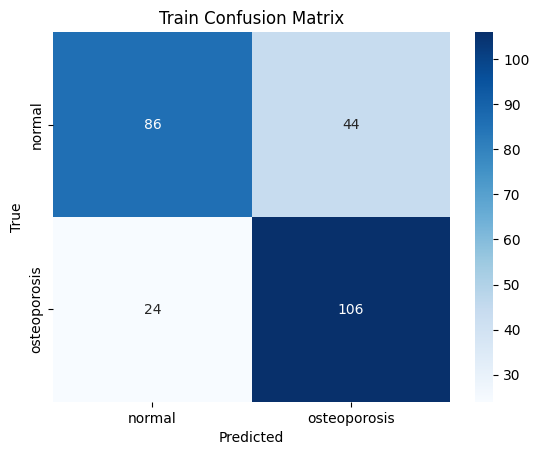


Validation -> Accuracy: 0.75
              precision    recall  f1-score   support

      normal       0.85      0.61      0.71        28
osteoporosis       0.69      0.89      0.78        28

    accuracy                           0.75        56
   macro avg       0.77      0.75      0.74        56
weighted avg       0.77      0.75      0.74        56



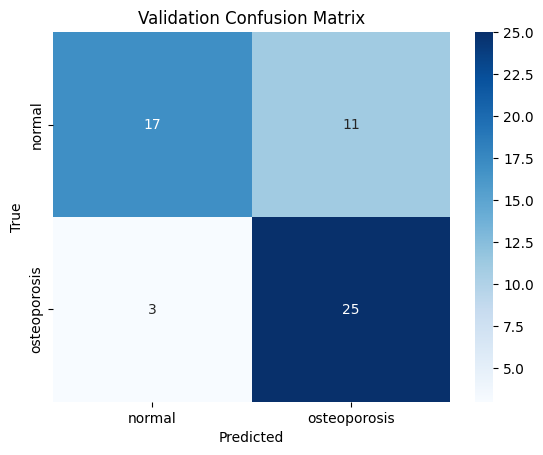


Test -> Accuracy: 0.6785714285714286
              precision    recall  f1-score   support

      normal       0.71      0.61      0.65        28
osteoporosis       0.66      0.75      0.70        28

    accuracy                           0.68        56
   macro avg       0.68      0.68      0.68        56
weighted avg       0.68      0.68      0.68        56



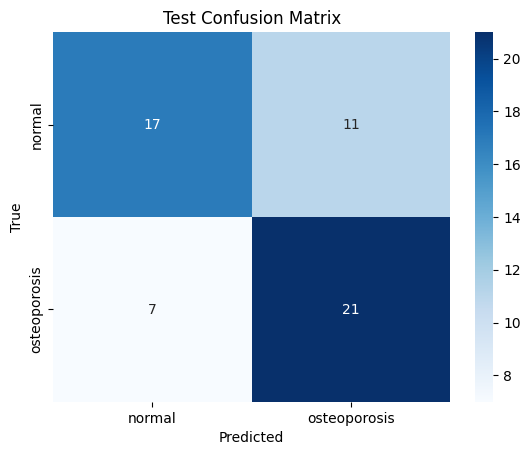


EVALUATION: PIPELINE 2 (Normalization Only)

Train -> Accuracy: 0.7346153846153847
              precision    recall  f1-score   support

      normal       0.77      0.66      0.71       130
osteoporosis       0.70      0.81      0.75       130

    accuracy                           0.73       260
   macro avg       0.74      0.73      0.73       260
weighted avg       0.74      0.73      0.73       260



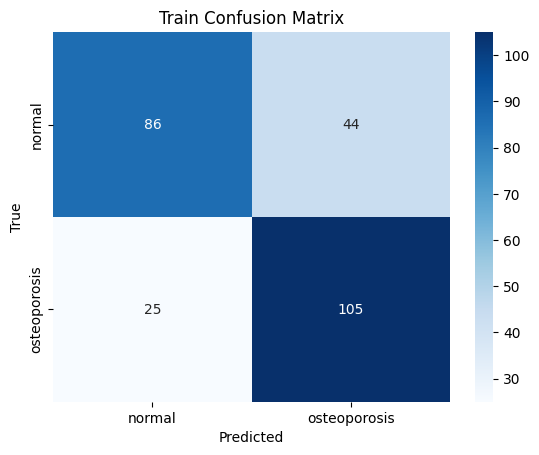


Validation -> Accuracy: 0.75
              precision    recall  f1-score   support

      normal       0.82      0.64      0.72        28
osteoporosis       0.71      0.86      0.77        28

    accuracy                           0.75        56
   macro avg       0.76      0.75      0.75        56
weighted avg       0.76      0.75      0.75        56



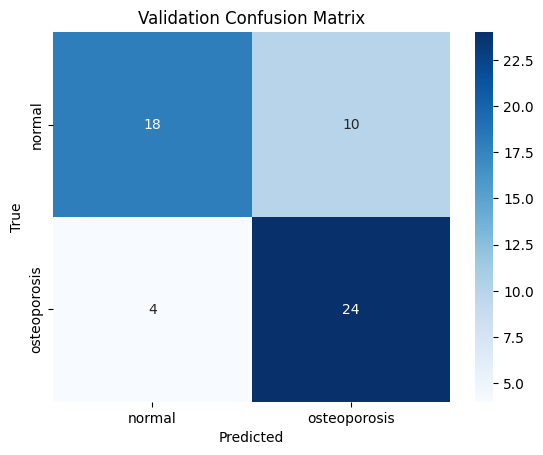


Test -> Accuracy: 0.8035714285714286
              precision    recall  f1-score   support

      normal       0.90      0.68      0.78        28
osteoporosis       0.74      0.93      0.83        28

    accuracy                           0.80        56
   macro avg       0.82      0.80      0.80        56
weighted avg       0.82      0.80      0.80        56



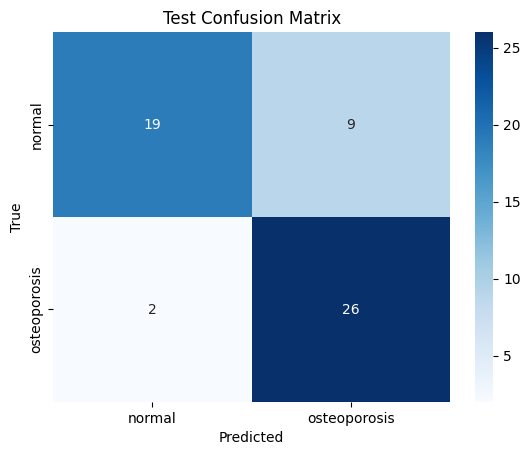


EVALUATION: PIPELINE 3 (Normalization + CLAHE)

Train -> Accuracy: 0.7230769230769231
              precision    recall  f1-score   support

      normal       0.74      0.68      0.71       130
osteoporosis       0.71      0.76      0.73       130

    accuracy                           0.72       260
   macro avg       0.72      0.72      0.72       260
weighted avg       0.72      0.72      0.72       260



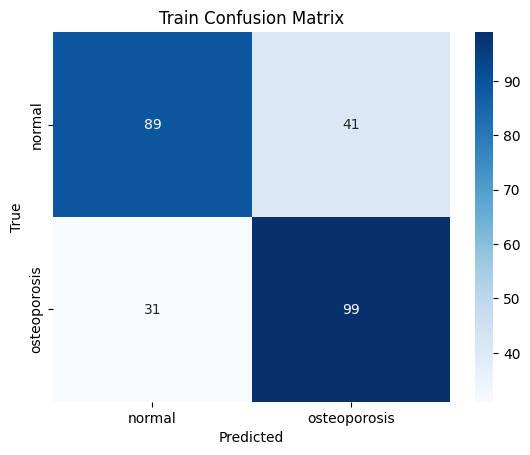


Validation -> Accuracy: 0.7321428571428571
              precision    recall  f1-score   support

      normal       0.78      0.64      0.71        28
osteoporosis       0.70      0.82      0.75        28

    accuracy                           0.73        56
   macro avg       0.74      0.73      0.73        56
weighted avg       0.74      0.73      0.73        56



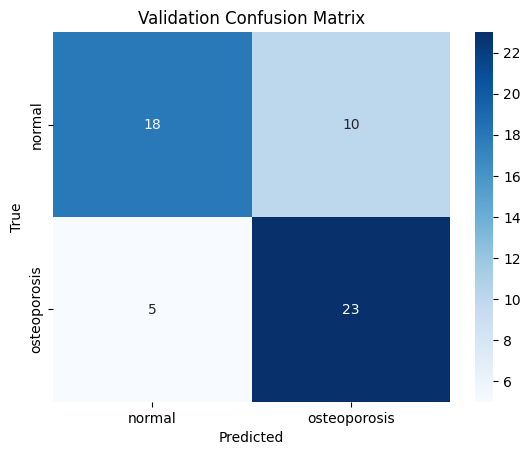


Test -> Accuracy: 0.7321428571428571
              precision    recall  f1-score   support

      normal       0.78      0.64      0.71        28
osteoporosis       0.70      0.82      0.75        28

    accuracy                           0.73        56
   macro avg       0.74      0.73      0.73        56
weighted avg       0.74      0.73      0.73        56



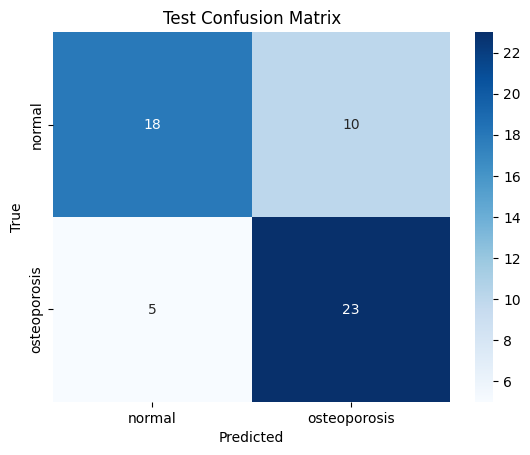


EVALUATION: PIPELINE 4 (Normalization + Denoising + CLAHE)

Train -> Accuracy: 0.6384615384615384
              precision    recall  f1-score   support

      normal       0.65      0.62      0.63       130
osteoporosis       0.63      0.66      0.65       130

    accuracy                           0.64       260
   macro avg       0.64      0.64      0.64       260
weighted avg       0.64      0.64      0.64       260



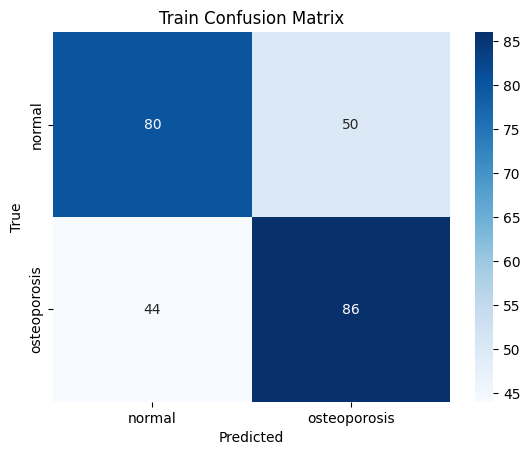


Validation -> Accuracy: 0.6071428571428571
              precision    recall  f1-score   support

      normal       0.65      0.46      0.54        28
osteoporosis       0.58      0.75      0.66        28

    accuracy                           0.61        56
   macro avg       0.62      0.61      0.60        56
weighted avg       0.62      0.61      0.60        56



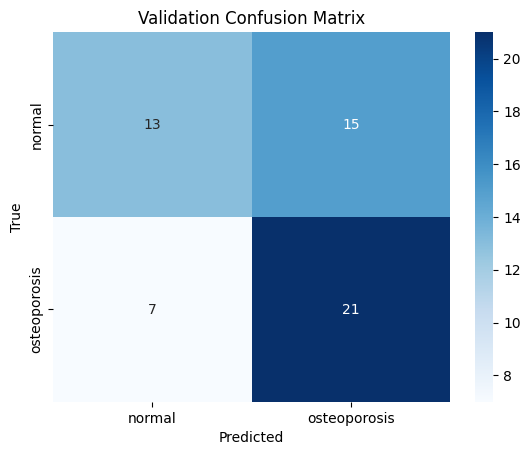


Test -> Accuracy: 0.6785714285714286
              precision    recall  f1-score   support

      normal       0.69      0.64      0.67        28
osteoporosis       0.67      0.71      0.69        28

    accuracy                           0.68        56
   macro avg       0.68      0.68      0.68        56
weighted avg       0.68      0.68      0.68        56



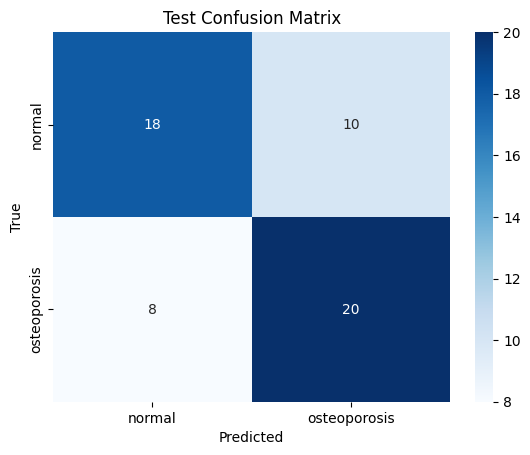


EVALUATION: PIPELINE 5 (Normalization + CLAHE + Data Augmentation)

Train -> Accuracy: 0.7038461538461539
              precision    recall  f1-score   support

      normal       0.70      0.71      0.70       130
osteoporosis       0.71      0.70      0.70       130

    accuracy                           0.70       260
   macro avg       0.70      0.70      0.70       260
weighted avg       0.70      0.70      0.70       260



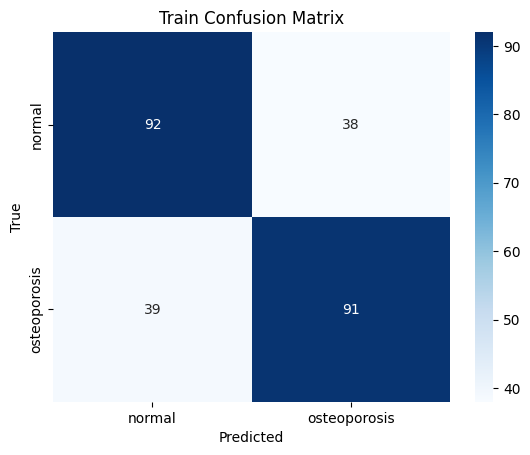


Validation -> Accuracy: 0.6785714285714286
              precision    recall  f1-score   support

      normal       0.69      0.64      0.67        28
osteoporosis       0.67      0.71      0.69        28

    accuracy                           0.68        56
   macro avg       0.68      0.68      0.68        56
weighted avg       0.68      0.68      0.68        56



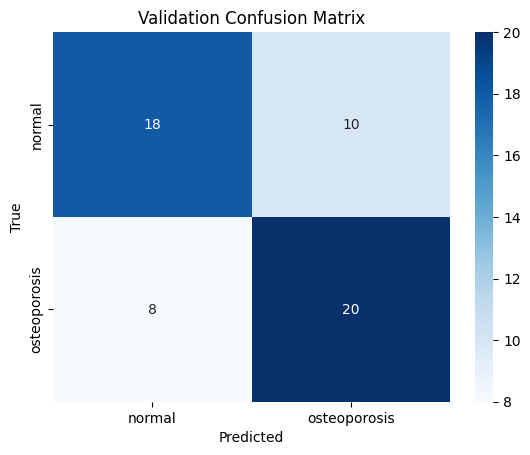


Test -> Accuracy: 0.6607142857142857
              precision    recall  f1-score   support

      normal       0.67      0.64      0.65        28
osteoporosis       0.66      0.68      0.67        28

    accuracy                           0.66        56
   macro avg       0.66      0.66      0.66        56
weighted avg       0.66      0.66      0.66        56



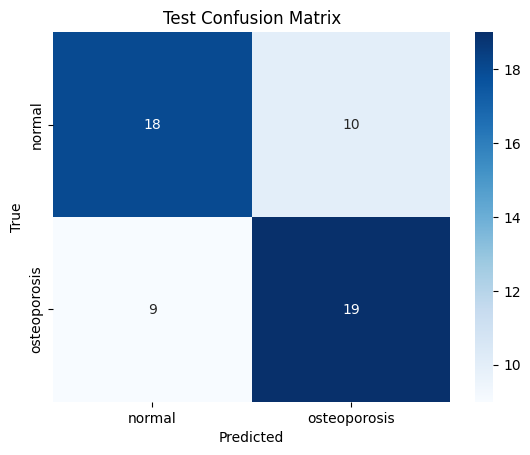


EVALUATION: PIPELINE 6 (CLAHE + Normalization + Augmentation + Dataset Expansion)

Train -> Accuracy: 0.7448717948717949
              precision    recall  f1-score   support

      normal       0.79      0.66      0.72       390
osteoporosis       0.71      0.83      0.76       390

    accuracy                           0.74       780
   macro avg       0.75      0.74      0.74       780
weighted avg       0.75      0.74      0.74       780



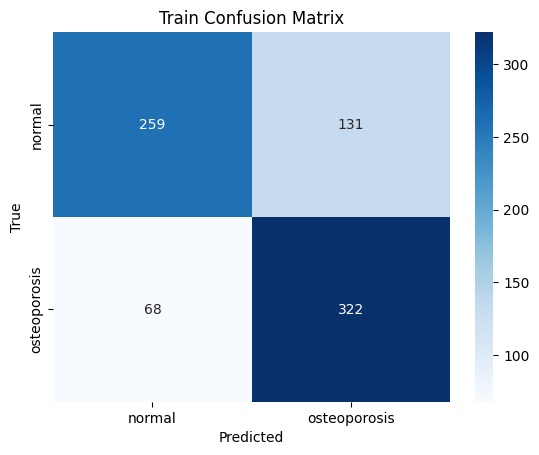


Validation -> Accuracy: 0.75
              precision    recall  f1-score   support

      normal       0.82      0.64      0.72        28
osteoporosis       0.71      0.86      0.77        28

    accuracy                           0.75        56
   macro avg       0.76      0.75      0.75        56
weighted avg       0.76      0.75      0.75        56



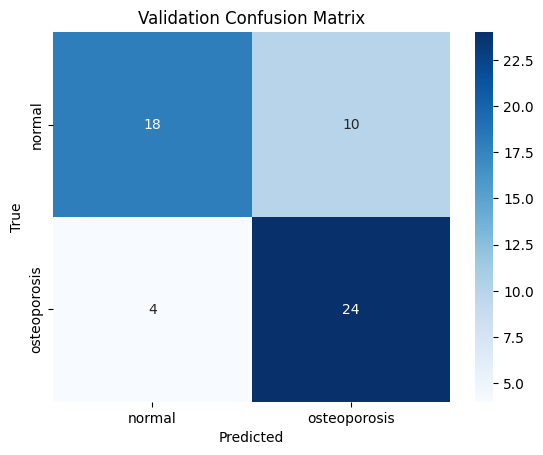


Test -> Accuracy: 0.8035714285714286
              precision    recall  f1-score   support

      normal       0.87      0.71      0.78        28
osteoporosis       0.76      0.89      0.82        28

    accuracy                           0.80        56
   macro avg       0.81      0.80      0.80        56
weighted avg       0.81      0.80      0.80        56



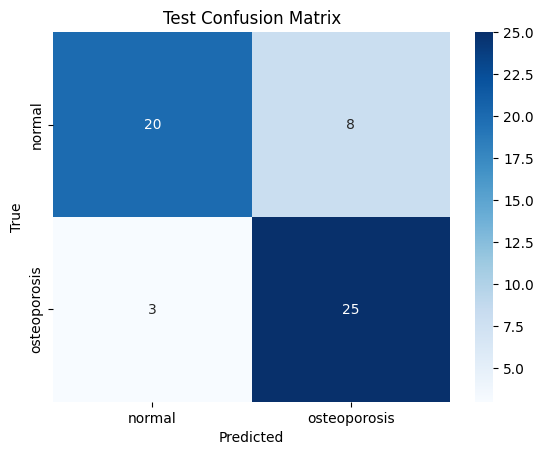

In [22]:
# Evaluate Pipelines

print("\nEVALUATION: PIPELINE 1 (Raw Images)")
evaluate_and_report(model_1, train_ds_1, "Train")
evaluate_and_report(model_1, val_ds_1, "Validation")
evaluate_and_report(model_1, test_ds_1, "Test")

print("\nEVALUATION: PIPELINE 2 (Normalization Only)")
evaluate_and_report(model_2, train_ds_2, "Train")
evaluate_and_report(model_2, val_ds_2, "Validation")
evaluate_and_report(model_2, test_ds_2, "Test")

print("\nEVALUATION: PIPELINE 3 (Normalization + CLAHE)")
evaluate_and_report(model_3, train_ds_3, "Train")
evaluate_and_report(model_3, val_ds_3, "Validation")
evaluate_and_report(model_3, test_ds_3, "Test")

print("\nEVALUATION: PIPELINE 4 (Normalization + Denoising + CLAHE)")
evaluate_and_report(model_4, train_ds_4, "Train")
evaluate_and_report(model_4, val_ds_4, "Validation")
evaluate_and_report(model_4, test_ds_4, "Test")

print("\nEVALUATION: PIPELINE 5 (Normalization + CLAHE + Data Augmentation)")
evaluate_and_report(model_5, train_ds_5, "Train")
evaluate_and_report(model_5, val_ds_5, "Validation")
evaluate_and_report(model_5, test_ds_5, "Test")

print("\nEVALUATION: PIPELINE 6 (CLAHE + Normalization + Augmentation + Dataset Expansion)")
evaluate_and_report(model_6, train_ds_6, "Train")
evaluate_and_report(model_6, val_ds_6, "Validation")
evaluate_and_report(model_6, test_ds_6, "Test")

In [25]:
# =========================
# PIPELINE 7: Normalization + Dataset Expansion
# =========================

def make_dataset_7(paths, labels, num_aug=2):
    """Build dataset with Normalization (preprocess_2) + Dataset Expansion"""
    base_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    base_ds = base_ds.map(preprocess_2, num_parallel_calls=AUTOTUNE)  # ✅ reuse preprocess_2

    # expand dataset: each image → original + num_aug augmentations
    base_ds = base_ds.flat_map(lambda x, y: augment_image(x, y, num_aug))  # ✅ reuse augment_image

    return base_ds.shuffle(512).batch(BATCH_SIZE).prefetch(AUTOTUNE)


# --- Build datasets for Pipeline 7 ---
train_ds_7 = make_dataset_7(train_paths, train_labels, num_aug=2)  # expanded
val_ds_7   = make_dataset_7(val_paths, val_labels, num_aug=0)      # no augmentation
test_ds_7  = make_dataset_7(test_paths, test_labels, num_aug=0)    # no augmentation

# --- Check sizes ---
train_count_7 = sum(1 for _ in train_ds_7.unbatch())
val_count_7   = sum(1 for _ in val_ds_7.unbatch())
test_count_7  = sum(1 for _ in test_ds_7.unbatch())

print("\n=== Pipeline 7 Dataset Sizes (Normalization + Expansion) ===")
print(f"Train set size: {train_count_7}")   # should be ~3× train_paths
print(f"Val set size  : {val_count_7}")     # same as val_paths
print(f"Test set size : {test_count_7}")    # same as test_paths



=== Pipeline 7 Dataset Sizes (Normalization + Expansion) ===
Train set size: 780
Val set size  : 56
Test set size : 56


In [26]:
# Model 7
base_model_7 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_7.trainable = False

model_7 = tf.keras.Sequential([
    base_model_7,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_7.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_7.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
print("\nTraining PIPELINE 7 (Normalization + Dataset Expansion)...\n")
history_7 = model_7.fit(train_ds_7, validation_data=val_ds_7, epochs=10)


Training PIPELINE 7 (Normalization + Dataset Expansion)...

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 527ms/step - accuracy: 0.5795 - loss: 0.7038 - val_accuracy: 0.6250 - val_loss: 0.6266
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 549ms/step - accuracy: 0.6154 - loss: 0.6896 - val_accuracy: 0.6429 - val_loss: 0.5918
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 643ms/step - accuracy: 0.6821 - loss: 0.6123 - val_accuracy: 0.6429 - val_loss: 0.5676
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 606ms/step - accuracy: 0.6936 - loss: 0.6224 - val_accuracy: 0.6786 - val_loss: 0.5524
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 874ms/step - accuracy: 0.6949 - loss: 0.5893 - val_accuracy: 0.7321 - val_loss: 0.5374
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 644ms/step - accuracy: 0.6987 - loss: 0.5990 - val_accuracy: 0.7679 - val_loss: 0.5261
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 544ms/step - accuracy: 0.6821 - loss: 0.5885 - val_accuracy: 0.7679 - val_loss: 0.5164
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━


EVALUATION: PIPELINE 7 (Normalization + Dataset Expansion)

Train -> Accuracy: 0.7782051282051282
              precision    recall  f1-score   support

      normal       0.84      0.69      0.76       390
osteoporosis       0.74      0.87      0.80       390

    accuracy                           0.78       780
   macro avg       0.79      0.78      0.78       780
weighted avg       0.79      0.78      0.78       780



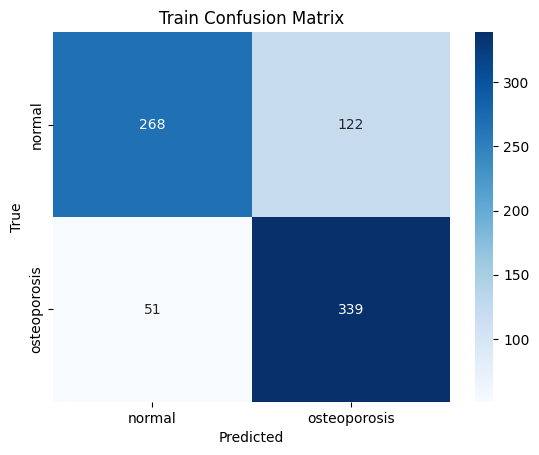


Validation -> Accuracy: 0.8035714285714286
              precision    recall  f1-score   support

      normal       0.95      0.64      0.77        28
osteoporosis       0.73      0.96      0.83        28

    accuracy                           0.80        56
   macro avg       0.84      0.80      0.80        56
weighted avg       0.84      0.80      0.80        56



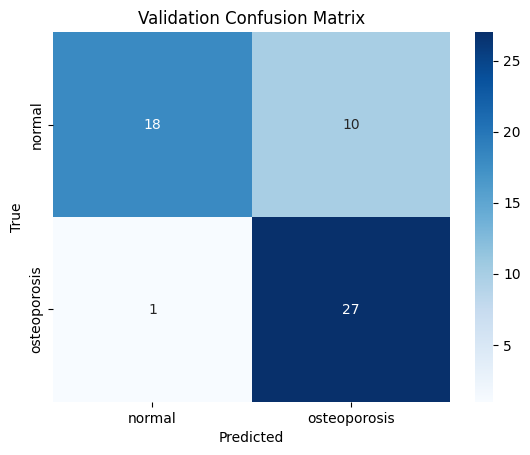


Test -> Accuracy: 0.8035714285714286
              precision    recall  f1-score   support

      normal       0.95      0.64      0.77        28
osteoporosis       0.73      0.96      0.83        28

    accuracy                           0.80        56
   macro avg       0.84      0.80      0.80        56
weighted avg       0.84      0.80      0.80        56



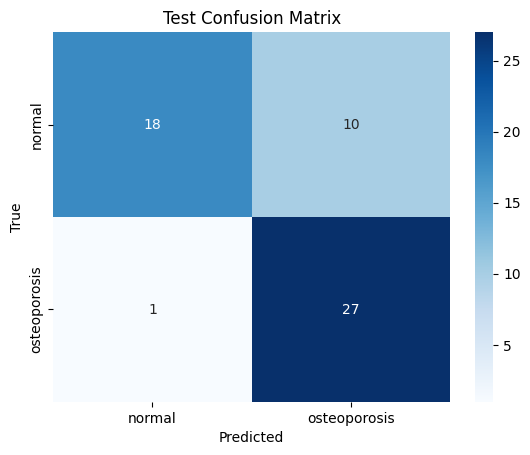

In [29]:
print("\nEVALUATION: PIPELINE 7 (Normalization + Dataset Expansion)")
evaluate_and_report(model_7, train_ds_7, "Train")
evaluate_and_report(model_7, val_ds_7, "Validation")
evaluate_and_report(model_7, test_ds_7, "Test")

In [31]:
# List of models and datasets
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]
datasets_train = [train_ds_1, train_ds_2, train_ds_3, train_ds_4, train_ds_5, train_ds_6, train_ds_7]
datasets_val   = [val_ds_1, val_ds_2, val_ds_3, val_ds_4, val_ds_5, val_ds_6, val_ds_7]
datasets_test  = [test_ds_1, test_ds_2, test_ds_3, test_ds_4, test_ds_5, test_ds_6, test_ds_7]

# Names for printing
pipeline_names = [
    "Pipeline 1: Raw Images",
    "Pipeline 2: Normalization",
    "Pipeline 3: Normalization + CLAHE",
    "Pipeline 4: Normalization + Denoising + CLAHE",
    "Pipeline 5: Normalization + CLAHE + Data Augmentation",
    "Pipeline 6: CLAHE + Normalization + Augmentation + Dataset Expansion",
    "Pipeline 7: Normalization + Dataset Expansion"
]

# Evaluation function
def evaluate_model(model, dataset):
    loss, acc = model.evaluate(dataset, verbose=0)
    return acc

# Loop through all pipelines
for i in range(7):
    print(f"\n=== {pipeline_names[i]} ===")
    
    train_acc = evaluate_model(models[i], datasets_train[i])
    val_acc   = evaluate_model(models[i], datasets_val[i])
    test_acc  = evaluate_model(models[i], datasets_test[i])
    
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")



=== Pipeline 1: Raw Images ===
Train Accuracy: 0.7385
Validation Accuracy: 0.7500
Test Accuracy: 0.6786

=== Pipeline 2: Normalization ===
Train Accuracy: 0.7346
Validation Accuracy: 0.7500
Test Accuracy: 0.8036

=== Pipeline 3: Normalization + CLAHE ===
Train Accuracy: 0.7231
Validation Accuracy: 0.7321
Test Accuracy: 0.7321

=== Pipeline 4: Normalization + Denoising + CLAHE ===
Train Accuracy: 0.6385
Validation Accuracy: 0.6071
Test Accuracy: 0.6786

=== Pipeline 5: Normalization + CLAHE + Data Augmentation ===
Train Accuracy: 0.6846
Validation Accuracy: 0.7321
Test Accuracy: 0.6786

=== Pipeline 6: CLAHE + Normalization + Augmentation + Dataset Expansion ===
Train Accuracy: 0.7410
Validation Accuracy: 0.7500
Test Accuracy: 0.8036

=== Pipeline 7: Normalization + Dataset Expansion ===
Train Accuracy: 0.7795
Validation Accuracy: 0.8036
Test Accuracy: 0.8036


C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


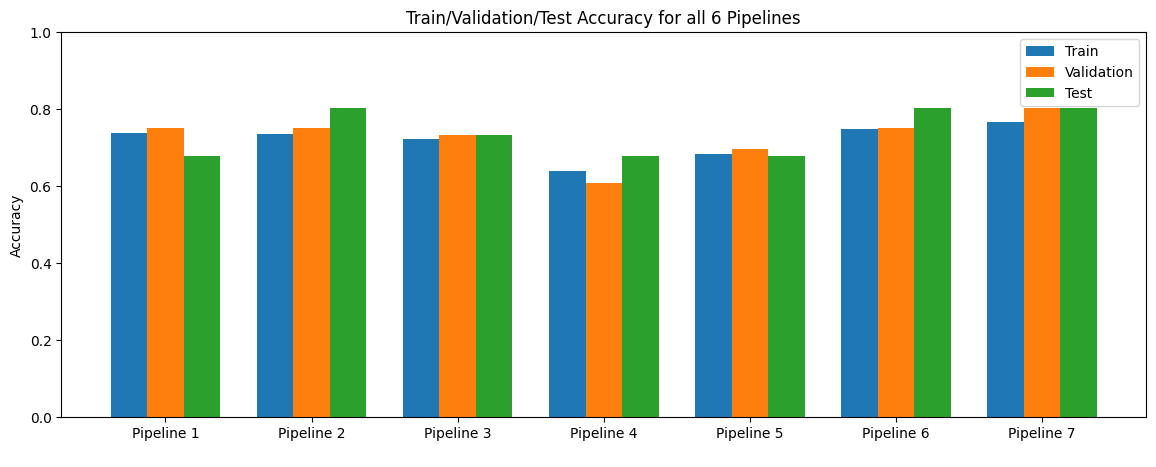

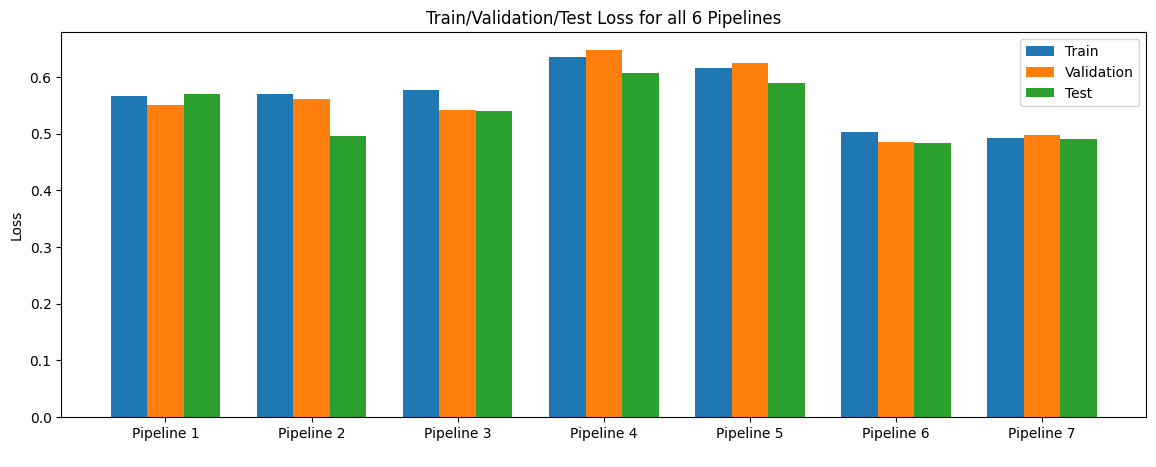

In [33]:
# ----------------------------
# Collect metrics
# ----------------------------
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]
datasets_train = [train_ds_1, train_ds_2, train_ds_3, train_ds_4, train_ds_5, train_ds_6, train_ds_7]
datasets_val   = [val_ds_1, val_ds_2, val_ds_3, val_ds_4, val_ds_5, val_ds_6, val_ds_7]
datasets_test  = [test_ds_1, test_ds_2, test_ds_3, test_ds_4, test_ds_5, test_ds_6, test_ds_7]

# pipeline_names = [
#     "Pipeline 1\nRaw",
#     "Pipeline 2\nNormalization",
#     "Pipeline 3\nNorm + CLAHE",
#     "Pipeline 4\nNorm + Denoise + CLAHE",
#     "Pipeline 5\nNorm + CLAHE + Aug",
#     "Pipeline 6\nCLAHE + Norm + Aug + Expansion",
#     "Pipeline 7\nNorm + Expansion"
# ]
pipeline_names = [
    "Pipeline 1\n",
    "Pipeline 2\n",
    "Pipeline 3\n",
    "Pipeline 4\n",
    "Pipeline 5\n",
    "Pipeline 6\n",
    "Pipeline 7\n"
]

train_acc, val_acc, test_acc = [], [], []
train_loss, val_loss, test_loss = [], [], []

for i in range(7):
    tl, ta = models[i].evaluate(datasets_train[i], verbose=0)
    vl, va = models[i].evaluate(datasets_val[i], verbose=0)
    tel, tea = models[i].evaluate(datasets_test[i], verbose=0)
    
    train_loss.append(tl)
    val_loss.append(vl)
    test_loss.append(tel)
    
    train_acc.append(ta)
    val_acc.append(va)
    test_acc.append(tea)

# ----------------------------
# Plot Accuracy
# ----------------------------
x = np.arange(len(pipeline_names))
width = 0.25

plt.figure(figsize=(14,5))
plt.bar(x - width, train_acc, width, label="Train")
plt.bar(x, val_acc, width, label="Validation")
plt.bar(x + width, test_acc, width, label="Test")
plt.xticks(x, pipeline_names)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Train/Validation/Test Accuracy for all 6 Pipelines")
plt.legend()
plt.show()

# ----------------------------
# Plot Loss
# ----------------------------
plt.figure(figsize=(14,5))
plt.bar(x - width, train_loss, width, label="Train")
plt.bar(x, val_loss, width, label="Validation")
plt.bar(x + width, test_loss, width, label="Test")
plt.xticks(x, pipeline_names)
plt.ylabel("Loss")
plt.title("Train/Validation/Test Loss for all 6 Pipelines")
plt.legend()
plt.show()


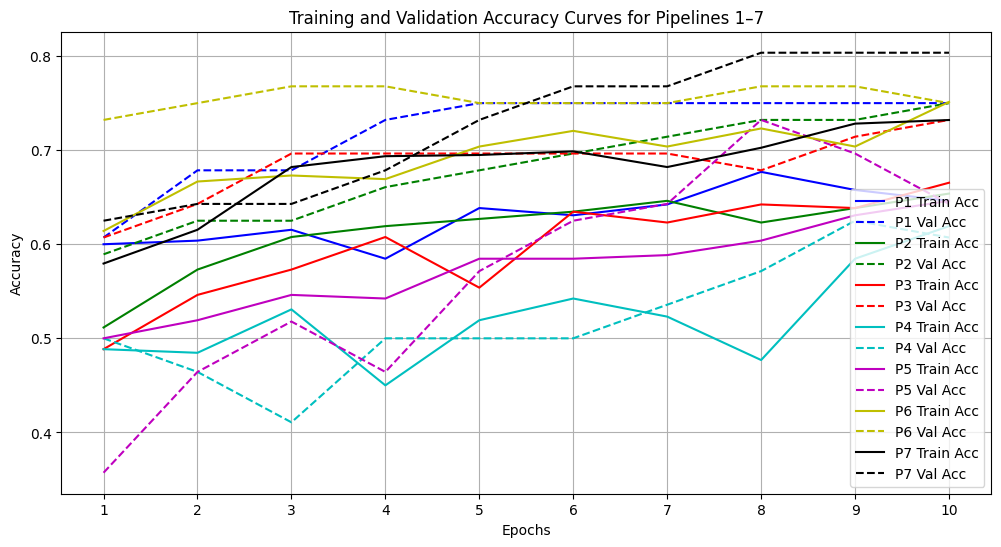

In [37]:
# Assume you have the history objects for each pipeline
# history_P1, history_P2, ..., history_P7
pipelines = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
histories = [history_1, history_2, history_3, history_4, history_5, history_6, history_7]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure(figsize=(12, 6))

for hist, label, color in zip(histories, pipelines, colors):
    # Plot training accuracy
    plt.plot(range(1, len(hist.history['accuracy']) + 1),
             hist.history['accuracy'], color=color, linestyle='-', label=f'{label} Train Acc')
    
    # Plot validation accuracy
    plt.plot(range(1, len(hist.history['val_accuracy']) + 1),
             hist.history['val_accuracy'], color=color, linestyle='--', label=f'{label} Val Acc')

plt.title('Training and Validation Accuracy Curves for Pipelines 1–7')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))  # Show epochs 1–10
plt.legend()
plt.grid(True)
plt.show()


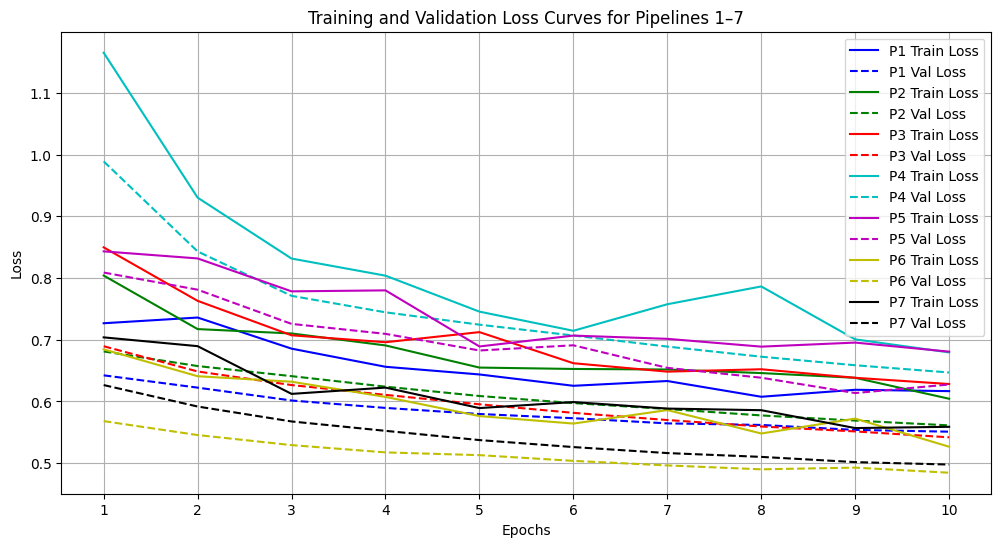

In [36]:
# Assume you have the history objects for each pipeline
# history_P1, history_P2, ..., history_P7
pipelines = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
histories = [history_1, history_2, history_3, history_4, history_5, history_6, history_7]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure(figsize=(12, 6))

for hist, label, color in zip(histories, pipelines, colors):
    # Plot training loss
    plt.plot(range(1, len(hist.history['loss']) + 1),
             hist.history['loss'], color=color, linestyle='-', label=f'{label} Train Loss')
    
    # Plot validation loss
    plt.plot(range(1, len(hist.history['val_loss']) + 1),
             hist.history['val_loss'], color=color, linestyle='--', label=f'{label} Val Loss')

plt.title('Training and Validation Loss Curves for Pipelines 1–7')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 11))  # Show epochs 1–10
plt.legend()
plt.grid(True)
plt.show()
